[1128e807-b450-436f-a7c7-8970b5273434] Fetching metadata via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Fetching data via API
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing metadata
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Parsing data
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Converting data to Pandas DataFrame
[Vessel Arrivals (>75 GT) Breakdown, Monthly] Column "vessel_type" does not appear to be numeric. Pandas says: "Unable to parse string "Tug" at position 0"


[Explorer] Analyzing "Vessel Arrivals (>75 GT) Breakdown, Monthly"
--------------------------------------------------
Describe
----------
       gross_tonnage  number_of_vessels                          month
count    5152.000000        5152.000000                           5152
mean    17890.043325        1363.890916  2008-05-16 15:30:11.180124160
min       115.960000         110.000000            1995-01-01 00:00:00
25%      1907.285000         787.000000            2001-09-01 00:00:00
50%      396

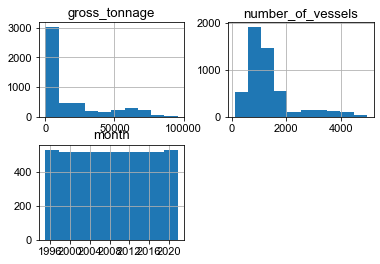

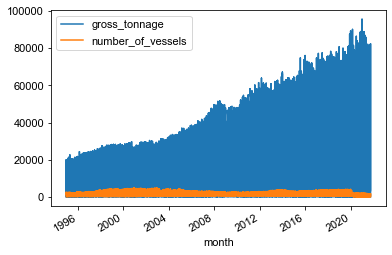

In [9]:
##Pre-import
import subprocess
import sys

try:
    import dataframe_image as dfi
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dataframe_image"])
finally:
    import dataframe_image as dfi

##Imports
#Standard
from functools import reduce
import re
import time

#Third-party
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Local
from Dataset import Dataset

#Fetch, clean, and sanity check data from Singapore Government API
dataset = Dataset("1128e807-b450-436f-a7c7-8970b5273434") # Vessel Arrivals (>75 GT), Monthly

# Data prep

In [10]:
#Pull dataframe and subsets into an easy reference dict and finish processing
data = {
    "arr":dataset.dataframe,
    "arr_p":dataset.dataframe[dataset.dataframe["vessel_type"] == "Passenger"],
    "arr_np":dataset.dataframe[dataset.dataframe["vessel_type"] != "Passenger"],
    "arr_np_type":dataset.dataframe[dataset.dataframe["vessel_type"] != "Passenger"]
}

def dataset_aggregate_by_month(dataset,key,agg_opts = {'gross_tonnage': 'sum', 'month': 'first', 'number_of_vessels': 'sum'}):
    df = dataset.copy()
    #Create aggregated total by month across types/purposes
    return df.groupby(df['month']).aggregate(agg_opts).reset_index(drop=True)

for key in data:
    #Arrivals data appears to double-count (row values for month/tonnage/no. vessels are each repeated twice), so clean duplicates
    #We don't do this in the Dataset class because it's possible seemingly duplicate rows might be an okay feature of a different dataset
    data[key] = data[key].drop_duplicates()
    #arr_np_type is meant to be monthly data split by type, which is the initial format of the data, so we do not need to aggregate
    if key != "arr_np_type":
        #Sum months across all vessel types to get a total for tonnage and arrivals for each month
        data[key] = dataset_aggregate_by_month(data[key],key)
    #Sort data by date
    data[key].sort_values(by="month",ascending=True,inplace=True)



# Charting

## Standard Charts - Arrivals, Vessels and Tonnage

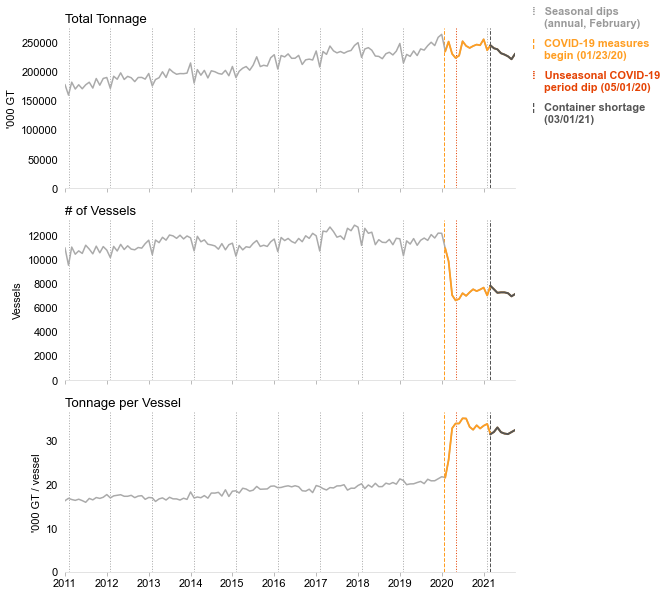

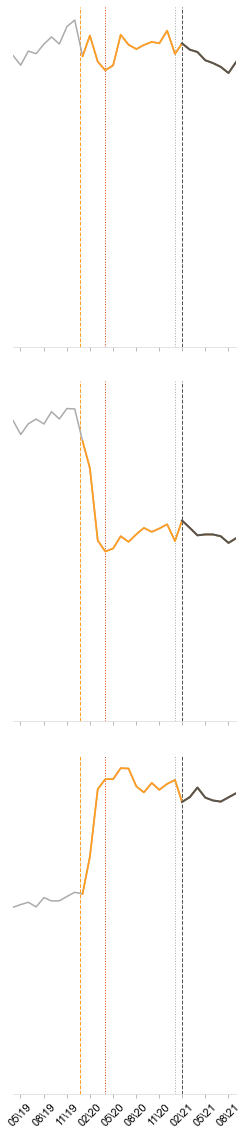

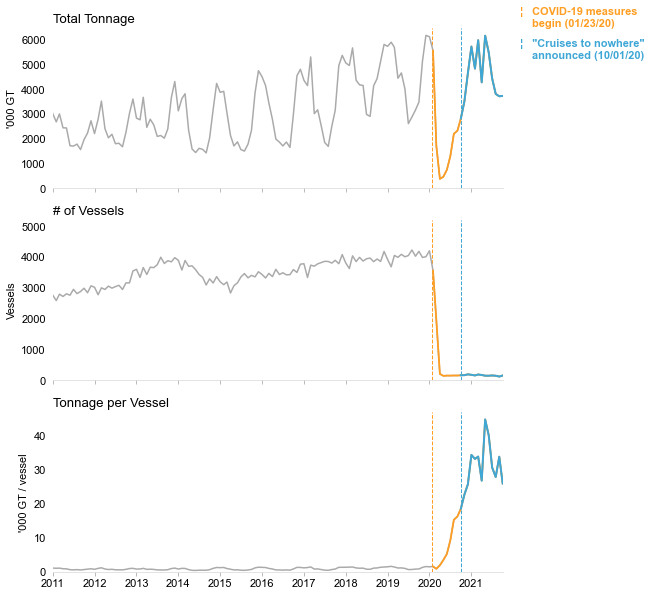

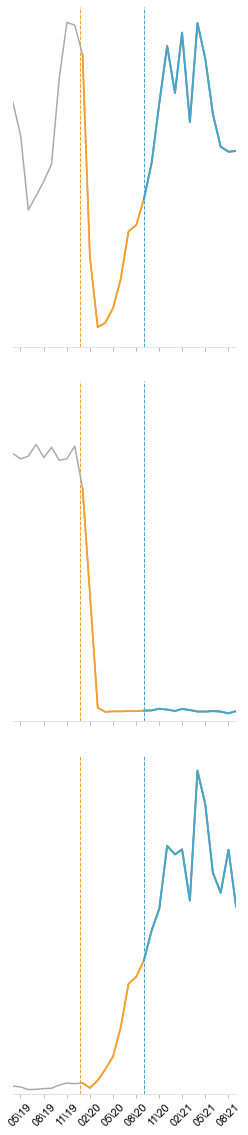

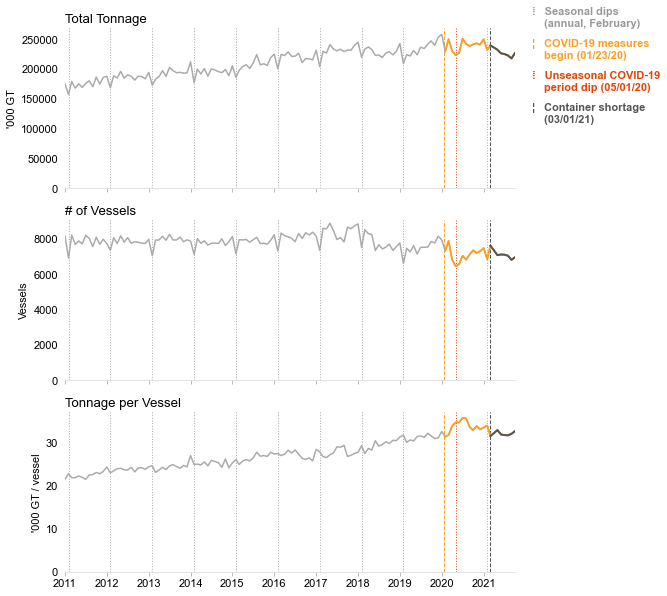

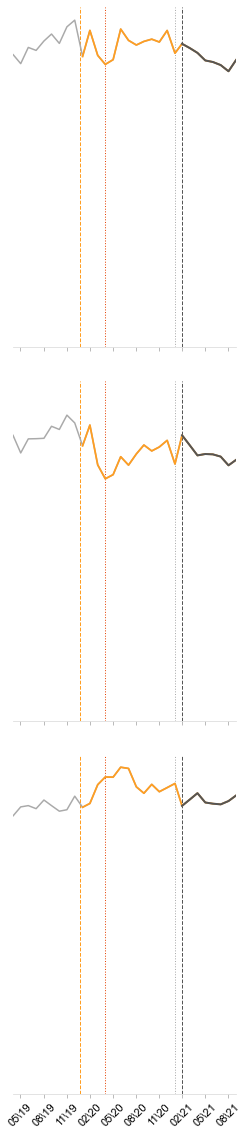

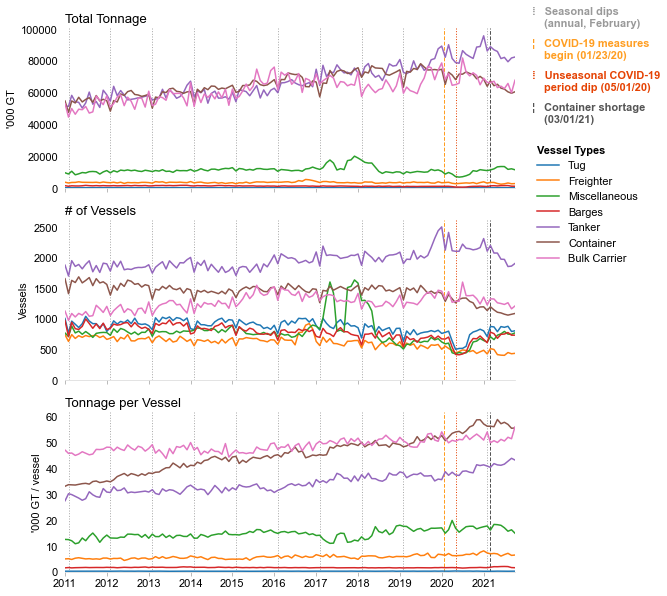

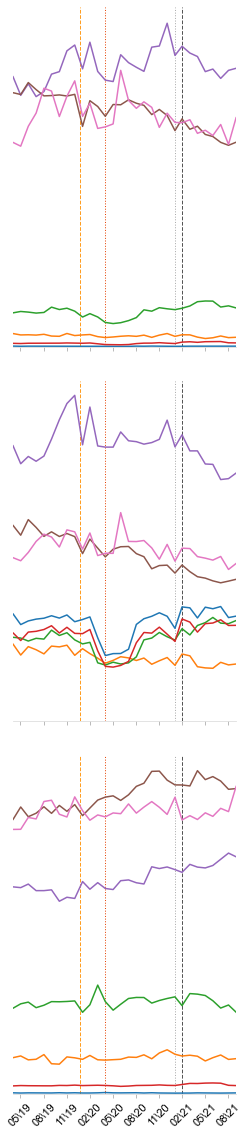

In [28]:
#Setup dates referenced below in Pandas datetime format for consistency
dates = {
    "covid_data": pd.to_datetime("2020-01-23"),
    "covid": pd.to_datetime("2020-01-23"),
    "cruise": pd.to_datetime("2020-10-01"),
    "covid_min": pd.to_datetime("2019-05-01"),
    "min": pd.to_datetime("2011-01-01"),
    "max": pd.to_datetime("2021-10-01"),
    "covid_dip": pd.to_datetime("2020-05-01"),
    "container": pd.to_datetime("2021-03-01")
}
#Setup reused colors
colors = {
    "lighter":"#ddd",
    "light":"#aaa",
    "dark":"#555",
    "covid":"#ff9e22",
    "cruise":"#3FA7D6",
    "red":"#e54304"
}
#Setup reused text labels (legend entries)
labels = {
    "covid":f'¦   COVID-19 measures\n    begin ({dates["covid"]:%m/%d/%y})',
    "cruise":f'¦   "Cruises to nowhere"\n    announced ({dates["cruise"]:%m/%d/%y})',
    "covid_dip":f'⁞   Unseasonal COVID-19\n    period dip ({dates["covid_dip"]:%m/%d/%y})',
    "recurring_dip":f'⁞   Seasonal dips\n    (annual, February)',
    "container":f'¦   Container shortage\n    ({dates["container"]:%m/%d/%y})' 
}

columns = {
    "gross_tonnage": "Total Tonnage",
    "number_of_vessels": "# of Vessels",
    "tonnage_per_vessel": "Tonnage per Vessel"
}

#Global settings
#For further customization of typography - ultimately not used for consistency with written report styling
#font_files = matplotlib.font_manager.findSystemFonts(fontpaths='./fonts/', fontext='ttf')
#for font_file in font_files:
#    matplotlib.font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "300"
plt.rcParams["font.size"] = "11"

class ArrivalsPlot():
    """
    Wrapper for consistent functionality to generate varieties of a timeseries plot from Singapore arrivals data
    
    Makes many assumptions specific to the arrivals data - would need to be adapted for use with other datasets

    Parameters
    ----------
    key:
        The key for the dataframe within the 'data' dict; functions as an identifier for the dataframe and plot
    df:
        The Pandas DataFrame containing the data to be plotted - should match what's provided for 'key'
    plots:
        An enumerable containing tuples in the format ([DataFrame field id], [label]) that will each be plotted as subplots
    is_inset:
        Boolean flag to apply inset/detail chart options
    """
    def __init__(self,key,df,plots,is_inset = False):
        self.key = key
        self.df = df
        self.is_inset = is_inset
        self.subplots = plots
        self.plot = {}
        #Passenger data/plots get some special handling
        self.is_passenger = self.key == 'arr_p'
        self.__setup__(self.subplots)

        #Step through subplots and draw, format, and annotate
        for m,metric in enumerate(self.subplots):
            self.draw_subplot(m,metric)
        if not self.is_inset:
            self.__annotate_subplot__(0)
        
    def __setup__(self,plots):
        #Data setup
        #Add tonnage_per_vessel metric to each dataframe
        self.df["tonnage_per_vessel"] = self.df["gross_tonnage"] / self.df["number_of_vessels"]
        #Create COVID, cruise to nowhere, and container shortage period DataFrames as relevant so these data subsets can be highlighted on plots
        self.df_covid = self.df[self.df["month"] >= dates["covid_data"]]
        if self.is_passenger:
            self.df_cruise = self.df[self.df["month"] >= dates["cruise"]]
        else: 
            self.df_container = self.df[self.df["month"] >= dates["container"]]

        #Chart setup
        self.plot["fig"], self.plot["ax"] = plt.subplots(len(plots), 1, sharex=True,figsize = (4,20) if self.is_inset else (10,10))
        #Limit plots to minimum overall display date, or just COVID period for inset/detail plots
        plt.xlim([(dates["covid_min"] if self.is_inset else dates["min"]),dates["max"]])
        plt.subplots_adjust(wspace=0, hspace=.2)
                  
    def __get_ax__(self,index = 0):
        #Returns subplot axis at a given index
        return self.plot["ax"] if isinstance(self.plot["ax"],matplotlib.axes.SubplotBase) else self.plot["ax"][index]

    def __format_subplot__(self,index = 0):
        #Set axis format and subplot spacing
        ax = self.__get_ax__(index)
                  
        #Minimalist axis display for clearer charts
        ax.tick_params(axis='x',bottom=True, color=colors["light"])
        ax.tick_params(axis='y',left=False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_edgecolor(colors["lighter"])
        ax.spines['bottom'].set_position('zero')

        if self.is_inset:
            #For inset/detail charts, show month axis labels and remove even more axis detail, which will be present on the main chart
            ax.set_yticks([])
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m\%y'))
            ax.set_xticks([date for date in pd.date_range(dates["covid_min"],dates["max"],freq="3M")])
            plt.xticks(rotation=45)
            ax.set_ylabel(None)
            ax.set_xlabel(None)
            plt.subplots_adjust(hspace=.1)

        else:
            plt.subplots_adjust(right=.75)
            
    def __draw_subplot_guides__(self,index = 0):
        #Adds the vertical line guides highlighting important dates/periods to plots
        ax = self.__get_ax__(index)
        y_min,y_max = ax.get_ylim()
        
        #All charts display COVID period guide
        lines = [dates["covid"]]
        line_colors = [colors["covid"]]
        line_styles = ["--"]
        
        if self.is_passenger:
            #Passenger charts display cruise to nowhere period guide
            lines += [dates["cruise"]]
            line_colors += [colors["cruise"]]
            line_styles += ["--"]
        else: 
            #Non-passenger charts show annual dip guides, COVID dip guide, and container shortage period guide
            dip_lines = [pd.to_datetime(f'{date.year}-02-01') for date in pd.date_range(dates["min"],pd.to_datetime("2021-12-31"),freq="1Y") if date.year != 2020]
            lines += dip_lines
            for line in dip_lines:
                line_colors += [colors["light"]]
                line_styles += [":"]
            lines += [dates["covid_dip"]]
            line_colors += [colors["red"]]
            line_styles += [":"]
            lines += [dates["container"]]
            line_colors += [colors["dark"]]
            line_styles += ["--"]
        ax.vlines(x=lines, color=line_colors, linestyle=line_styles,ymin=y_min,ymax=y_max,linewidth=1)

    def __annotate_subplot__(self,index = 0):
        #Adds labels for vertical line guides to plot
        ax = self.__get_ax__(index)
        x_min,x_max = ax.get_xlim()
        y_min,y_max = ax.get_ylim()
        
        #Guide annotations all positioned off chart to the right
        label_x = mdates.num2date(x_max + 150)
        
        #Common annotation options
        label_args = {
            "annotation_clip":False,
            "horizontalalignment":'left', 
            "verticalalignment":'bottom',
            "fontsize": 11,
            "fontweight": 800
        }
        
        #Following same logic as vertical line guides, annotate based on type of data on chart          
        if self.is_passenger:
            ax.annotate(labels["covid"],
                xy=(label_x, y_max),
                c=colors["covid"],
                **label_args
                )
            
            ax.annotate(labels["cruise"],
                xy=(label_x, y_max*.8),
                c=colors["cruise"],
                **label_args
                )
            
        else:
            ax.annotate(labels["recurring_dip"],
                xy=(label_x, y_max),
                c="#999",
                **label_args
                )
            
            ax.annotate(labels["covid"],
                xy=(label_x, y_max*.8),
                c=colors["covid"],
                **label_args
                )

            ax.annotate(labels["covid_dip"],
                xy=(label_x, y_max*.6),
                c=colors["red"],
                **label_args
                )
            
            ax.annotate(labels["container"],
                xy=(label_x, y_max*.4),
                c=colors["dark"],
                **label_args
                )
                  
    def draw_subplot(self,index,metric):
        #Handles creation and rendering of subplots
        ax = self.__get_ax__(index)
        field_meta = dataset._get_field_meta(metric[0])
        if (field_meta):
            #Display unit of measure as provided by data API metadata
            ax.set_ylabel(field_meta['unit_of_measure'])
        else:
            #Tonnage per vessel doesn't have a label because it isn't in the data API, provide default
            ax.set_ylabel("'000 GT / vessel")
        if "vessel_type" in self.df:
            #Handle data disaggregated by vessel type as multiple line plots on the same axis
            vessel_types = self.df["vessel_type"].unique()
            for vtype in vessel_types:
                #Loop through all vessel types and plot
                ax.plot("month",metric[0],data=self.df[self.df["vessel_type"] == vtype],label=vtype)
            if not self.is_inset and index == 0:
                #For non-inset/detail charts, add a legend to the first subplot showing vessel types
                legend = ax.legend(loc=(1.04,-.5),title="Vessel Types",frameon=False)
                legend.get_title().set_fontweight(800)
                legend._legend_box.align = "left"
        else:
            #Handle data aggregated by month as a single plot per axis for each time period (all time, COVID period)
            ax.plot("month",metric[0],data=self.df,color=colors["light"])
            ax.plot("month",metric[0],data=self.df_covid,color=colors["covid"],linewidth=1.8)
            if self.is_passenger:
                #Passenger data also get a plot for the cruise to nowhere period data
                ax.plot("month",metric[0],data=self.df_cruise,color=colors["cruise"],linewidth=2)
            else:
                #Non-passenger data also get a plot for the container shortage period data
                ax.plot("month",metric[0],data=self.df_container,color=colors["dark"],linewidth=2)
        #Standardize 0 minimum y-axis
        ax.set_ylim(0)
        if not self.is_inset:
            ax.set_title(metric[1],loc='left')
            
        self.__draw_subplot_guides__(index)
        self.__format_subplot__(index)
    
    def print_plot(self):
        #Output plot to local file
        self.plot["fig"].savefig(f'./figure_{self.key}{"_detail" if self.is_inset else ""}.jpg', dpi=300,bbox_inches='tight')

for key,df in data.items():
    #Create and save a group of timeseries subplots for selected metrics of each dataframe subset
    plot_main = ArrivalsPlot(key,df,[col for col in columns.items()])
    plot_detail = ArrivalsPlot(key,df,[col for col in columns.items()],True)
    plot_main.print_plot()
    plot_detail.print_plot()

# Data tables

In [110]:
def get_df_date_range(df,start,end):
    #Helper to extract two rows from a DataFrame based on month date
    return df[(df["month"] == end) | (df["month"] == start)]

def change_table(df):
    #Render a stylized table showing % change between rows in a DataFrame
    df = df.copy()
    df = df.rename(columns={"month":"Month"})
    style_format = {
        "Month":"{:%b '%y}".format
    }
    cols = ["Month"]
    for col in columns.items():
        df = df.rename(columns=dict([col]))
        label_change = f'% Change ({col[1]})'
        df[label_change] = df[col[1]].pct_change() * 100
        style_format[col[1]] = '{:,.2f}'.format
        style_format[label_change] = '{:,.2f}%'.format
        cols.append(col[1])
        cols.append(label_change)

    table = df[cols].style.hide_index().format(style_format,na_rep="")
    display(table)
    return table

dateranges = [
    ("arr_np","2020-03-01","2020-05-01"),
    ("arr_np","2021-03-01","2021-09-01"),
    ("arr_np","2021-09-01","2021-10-01"),
    ("arr_p","2019-12-01","2020-04-01")
]

for r in dateranges:
    table = change_table(get_df_date_range(data[r[0]],pd.to_datetime(r[1]),pd.to_datetime(r[2])))
    dfi.export(table,f'table-{r[0]}_{r[1]}_{r[2]}.jpg')


Month,Total Tonnage,% Change (Total Tonnage),# of Vessels,% Change (# of Vessels),Tonnage per Vessel,% Change (Tonnage per Vessel)
Mar '20,"249,678.71",,"7,882.00",,31.68,
May '20,"222,866.72",-10.74%,"6,449.00",-18.18%,34.56,9.10%


Month,Total Tonnage,% Change (Total Tonnage),# of Vessels,% Change (# of Vessels),Tonnage per Vessel,% Change (Tonnage per Vessel)
Mar '21,"239,115.54",,"7,611.00",,31.42,
Sep '21,"217,434.33",-9.07%,"6,808.00",-10.55%,31.94,1.66%


Month,Total Tonnage,% Change (Total Tonnage),# of Vessels,% Change (# of Vessels),Tonnage per Vessel,% Change (Tonnage per Vessel)
Sep '21,"217,434.33",,"6,808.00",,31.94,
Oct '21,"226,323.35",4.09%,"6,954.00",2.14%,32.55,1.90%


Month,Total Tonnage,% Change (Total Tonnage),# of Vessels,% Change (# of Vessels),Tonnage per Vessel,% Change (Tonnage per Vessel)
Dec '19,"6,160.93",,"4,001.00",,1.54,
Apr '20,371.15,-93.98%,195.00,-95.13%,1.90,23.60%
